In [5]:
from typing import Tuple
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import torch

from adabmDCA.custom_fn import one_hot
from adabmDCA.io import load_chains, load_params
from adabmDCA.fasta_utils import get_tokens, encode_sequence, import_from_fasta
from adabmDCA.stats import resample_sequences
from adabmDCA.stats import (
    extract_Cij_from_freq,
    get_freq_single_point,
    get_correlation_two_points,
    get_freq_two_points
)

In [2]:
device = "cuda"

In [3]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [4]:
fname_model = "/home/lorenzo/Documents/adabmDCApy/example_models/PF00072/PF00072bm_params_AP.dat"
fname_chains = "/home/lorenzo/Documents/adabmDCApy/example_models/PF00072/PF00072_samples.fasta"
fname_data = "/home/lorenzo/Documents/adabmDCApy/example_data/PF00072.fasta"
fname_weights = "/home/lorenzo/Documents/adabmDCApy/example_models/PF00072/bmDCA_weights.dat"

In [6]:
names, sequences = import_from_fasta(fname_data)

In [12]:
tokens = get_tokens("protein")
encode_sequence(sequences[0], tokens=tokens).shape

(112,)

In [5]:
ngen = 10000
tokens = get_tokens("protein")

data = torch.tensor(load_chains(fname_data, tokens))
weights = torch.tensor(np.loadtxt(fname_weights))
data = resample_sequences(data, weights, ngen).to(device)

data = one_hot(data, num_classes=len(tokens))
params = load_params(fname_model, tokens=tokens, device=device)


In [6]:
fname_results = "/home/lorenzo/Documents/adabmDCApy/example_models/PF00072/PF00072_log.csv"
results = pd.read_csv(fname_results)
mixing_time = results["t_half"].values[-1]

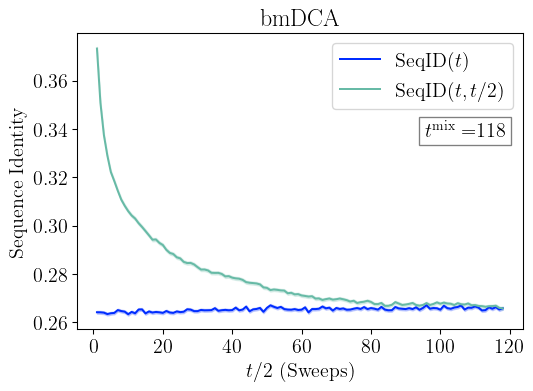

In [7]:
fig = plt.figure(figsize=(6, 4), dpi=96)
plt.plot(results["t_half"], results["seqid_t"], label=r"SeqID$(t)$", color="#002CFF")  # Blue
plt.fill_between(results["t_half"], 
                 np.array(results["seqid_t"]) - np.array(results["std_seqid_t"]), 
                 np.array(results["seqid_t"]) + np.array(results["std_seqid_t"]), 
                 color="#002CFF", alpha=0.2)
plt.plot(results["t_half"], results["seqid_t_t_half"], label=r"SeqID$(t, t/2)$", color="#67BAA6")  # Orange
plt.fill_between(results["t_half"], 
                 np.array(results["seqid_t_t_half"]) - np.array(results["std_seqid_t_t_half"]), 
                 np.array(results["seqid_t_t_half"]) + np.array(results["std_seqid_t_t_half"]), 
                 color="#67BAA6", alpha=0.2)
plt.xlabel(r"$t/2$ (Sweeps)")
plt.ylabel("Sequence Identity")
plt.legend(loc='upper right')
plt.title("bmDCA")


# Add annotation for mixing time
plt.annotate(r"$t^{\mathrm{mix}}=$" + f"{mixing_time}", xy=(0.96, 0.7), xycoords='axes fraction', fontsize=15,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [8]:
data_oh = data.reshape(data.shape[0], -1)
_, _, Vt = torch.svd(data_oh - data_oh.mean(0))
data_proj = (data_oh @ Vt) / data.shape[1]**0.5

samples = one_hot(torch.tensor(load_chains(fname_chains, tokens), device=device), num_classes=len(tokens))
gen_oh = samples.reshape(samples.shape[0], -1)
gen_proj = (gen_oh @ Vt) / data.shape[1]**0.5

/tmp/ipykernel_1466800/2088384472.py:2: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:697.)
  _, _, Vt = torch.svd(data_oh - data_oh.mean(0))


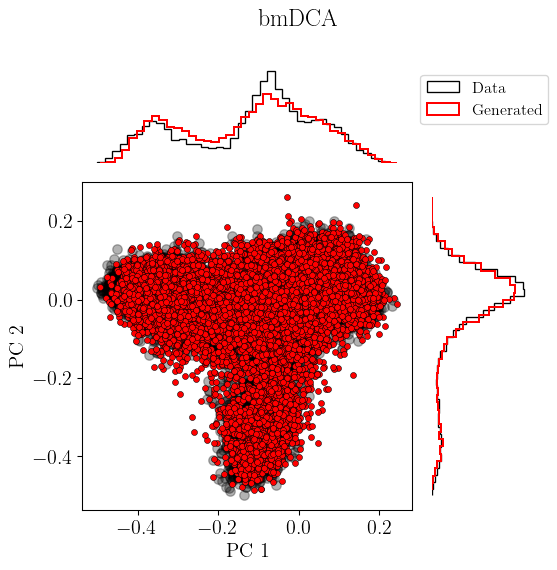

In [9]:
from adabmDCA.plot import plot_PCA

fig = plt.figure(figsize=(6, 6), dpi=96)
fig = plot_PCA(fig, data_proj.cpu().numpy(), gen_proj.cpu().numpy(), title="bmDCA", labels=["Data", "Generated"], dim1=0, dim2=1)

In [36]:
fi = get_freq_single_point(data, weights=None)
pi = get_freq_single_point(samples, weights=None)
fij = get_freq_two_points(data, weights=None)
pij = get_freq_two_points(samples, weights=None)
pearson, slope = get_correlation_two_points(fi=fi, pi=pi, fij=fij, pij=pij)


In [37]:
fij_extract, pij_extract = extract_Cij_from_freq(fi=fi, pi=pi, fij=fij, pij=pij)

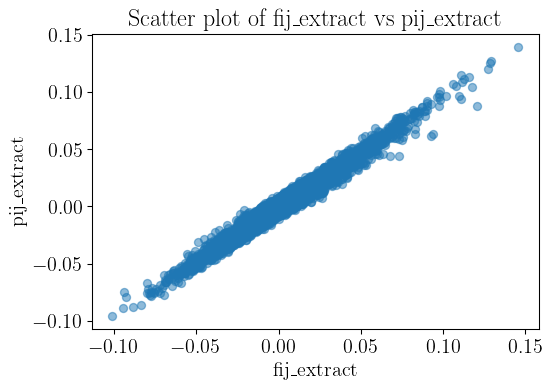

In [38]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=96)
ax.scatter(fij_extract.cpu().numpy(), pij_extract.cpu().numpy(), alpha=0.5)
ax.set_xlabel('fij_extract')
ax.set_ylabel('pij_extract')
ax.set_title('Scatter plot of fij_extract vs pij_extract')
plt.show()

In [39]:
print(f"Pearson correlation: {pearson:.3f}, slope: {slope:.3f}")

Pearson correlation: 0.935, slope: 0.864


### Represent the trajectory of the sampling

In [35]:
from adabmDCA.sampling import gibbs_sampling

# Load the model parameters
params = load_params(fname_model, tokens=tokens, device=device)
# Initialize the chains
chains = torch.randint(0, len(tokens), (2, data.shape[1]), device=device)
chains = one_hot(chains, num_classes=len(tokens))

confs = []
nsweeps = 1000

for _ in tqdm(range(nsweeps)):
    chains = gibbs_sampling(chains, params, nsweeps=1)
    proj_chains = (chains.view(len(chains), -1) @ Vt) / data.shape[1]**0.5
    confs.append(proj_chains[:, :2].unsqueeze(0).cpu().numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
confs = np.concatenate(confs, axis=0).transpose(1, 0, 2)

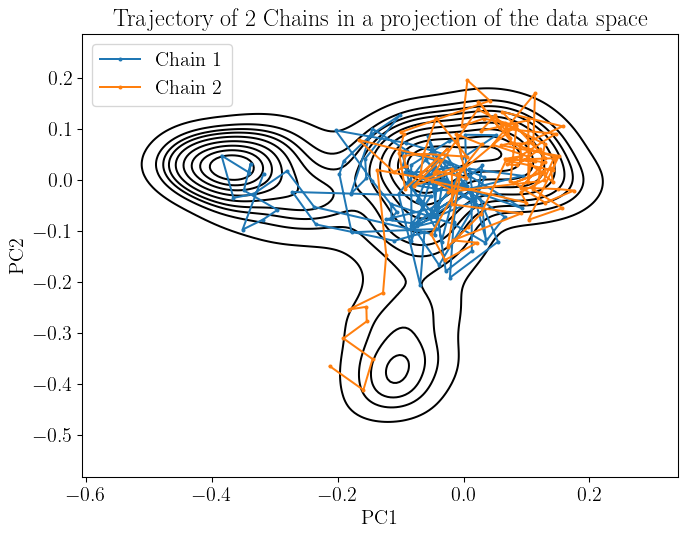

In [46]:
import seaborn as sns

# Convert data_proj to a numpy array and select the first two directions
data_proj_np = data_proj.cpu().numpy()[:, :2]

# Create a DataFrame for seaborn
df_proj = pd.DataFrame(data_proj_np, columns=['PC1', 'PC2'])

# Plot the density plot with contour lines
nsweeps_plot = 110
plt.figure(figsize=(8, 6), dpi=96)
sns.kdeplot(data=df_proj, x='PC1', y='PC2', fill=False, color='black', levels=10)

# Superimpose the trajectory of the 2 chains
for i in range(confs.shape[0]):
    plt.plot(confs[i, :nsweeps_plot, 0], confs[i, :nsweeps_plot, 1], marker='o', markersize=2, label=f'Chain {i+1}')

plt.title('Trajectory of 2 Chains in a projection of the data space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()